# Earnings Forecast - Roland Berger Analytics Screening

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report

In [2]:
sp500 = pd.read_csv('SP500_FUND_A_16052019.csv', index_col=0)

print('Number of rows: ', sp500.shape[0])
print('Number of Features: ', sp500.shape[1])

sp500.head()

Number of rows:  5339
Number of Features:  118


,ticker,date,year,month,day,fyear,fmonth,ass_c_y,ass_nc_y,ass_tax_y,...,rat_y,rev_r_d_y,rev_s_g_a_y,roic_y,turn_acc_pay_y,turn_acc_rec_y,turn_inv_y,wrk_cap_y,fyearold,n2
v1,,,,,,,,,,,,,,,,,,,,,
1,a,2007-10-31,2007,10,31,2007,10,3.671000e+09,3.883000e+09,0.0,...,2.207,0.1264,0.3137,0.1490,4.1255,7.5964,8.5354,2.008000e+09,2007,1
2,a,2008-10-31,2008,10,31,2008,10,3.182000e+09,3.825000e+09,0.0,...,2.392,0.1219,0.2939,0.1864,4.6941,7.6731,8.9589,1.852000e+09,2008,1
3,a,2009-10-31,2009,10,31,2009,10,3.961000e+09,3.651000e+09,0.0,...,3.527,0.1433,0.3577,0.0121,3.7951,6.5656,7.4808,2.838000e+09,2009,1
4,a,2010-10-31,2010,10,31,2010,10,6.169000e+09,3.527000e+09,0.0,...,2.001,0.1124,0.3218,0.0905,3.9107,7.4372,8.5868,3.086000e+09,2010,1
5,a,2011-10-31,2011,10,31,2011,10,5.569000e+09,3.488000e+09,0.0,...,3.032,0.0981,0.2735,0.1700,3.5592,7.6518,8.1970,3.732000e+09,2011,1


## 1. Data Preparation

### 1.1 Dataset containing 23 predictors

In [3]:
selection = ['ticker', 'date', 'year', 'month', 'day', 'fyear', 'fmonth', 'shr_y', 'ass_tot_y', 'goodwill_y', 'inc_rea_y', 'invest_y', 'rev_def_y', 'dps_y',
                'exp_r_d_y', 'marg_profit_y', 'rev_grw_y', 'cf_inv_y', 'exp_cap_y',
                'ncf_bad_y', 'ncf_iad_y', 'g_cf_op_y', 'g_dps_y', 'g_eps_y', 'g_inv_y',
                'be_ps_y', 'fcf_ps_y', 'inc_qua_y', 'payout_y', 'turn_inv_y', 'eps_y']


sp500_selected = sp500[selection]

### Handling Missing Data

In [4]:
# calculate count and percentage
missing_count = sp500_selected.isnull().sum()
missing_pct = (sp500_selected.isnull().mean() * 100)

# combine into a clean DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_pct
})

# sort by percentage descending
missing_summary = missing_summary.sort_values(by='Missing %', ascending=False)

# filter to show only columns that have missing data
missing_only = missing_summary[missing_summary['Missing Count'] > 0]

# print
print("--- Missing Data Summary ---")
if not missing_only.empty:
    display(missing_only.style.background_gradient(cmap='Reds', subset=['Missing %']).format({'Missing %': "{:.2f}%"}))
else:
    print("No missing values found in the selected subset!")

--- Missing Data Summary ---


,Missing Count,Missing %
turn_inv_y,119,2.23%
g_inv_y,112,2.10%
inc_rea_y,111,2.08%
payout_y,95,1.78%
g_eps_y,89,1.67%
fcf_ps_y,80,1.50%
be_ps_y,80,1.50%
rev_grw_y,77,1.44%
inc_qua_y,77,1.44%
shr_y,71,1.33%


Generally speaking, the share of missing data is very low. We will handle it, however, this will most likely not have a significant impact on our models.

In [ ]:
def handle_missing_data(df, predictors, drop_threshold=0.5):
    """
    1. Removes companies with > 50% missing data.
    2. Imputes missing values using Ticker Mean (Primary).
    3. Imputes remaining missing values using Global Mean (Secondary).
    """
    df_clean = df.copy()
    
    # 1. step: deletion
    
    # calculate percentage of missing data per 'ticker' across all predictor columns
    ticker_missing_pct = df_clean.groupby('ticker')[predictors].apply(
        lambda x: x.isnull().mean().mean()
    )
    
    # identify tickers with > 50% missing data
    bad_tickers = ticker_missing_pct[ticker_missing_pct > drop_threshold].index.tolist()
    
    # drop according to step 1
    initial_rows = len(df_clean)
    df_clean = df_clean[~df_clean['ticker'].isin(bad_tickers)]
    dropped_rows = initial_rows - len(df_clean)
    
    print(f"Rule: Drop tickers with > {drop_threshold*100}% missing data.")
    print(f"Dropped {len(bad_tickers)} companies ({dropped_rows} rows).")
    
    # 2. step: imputation

    impute_stats = {'Ticker_Imputed': 0, 'Global_Imputed': 0}
    
    for col in predictors:
        # check if column has missing data
        n_missing = df_clean[col].isnull().sum()
        if n_missing == 0:
            continue
            
        # 1) calculate mean per ticker
        # transform('mean') broadcasts the group mean to every row of that group
        ticker_means = df_clean.groupby('ticker')[col].transform('mean')
        
        # 2) fill with Ticker Mean first
        filled_by_ticker = df_clean[col].fillna(ticker_means)
        n_fixed_ticker = n_missing - filled_by_ticker.isnull().sum()
        impute_stats['Ticker_Imputed'] += n_fixed_ticker
        
        # apply
        df_clean[col] = filled_by_ticker
        
        # 3) fill remaining with global mean
        remaining_missing = df_clean[col].isnull().sum()
        if remaining_missing > 0:
            global_mean = df_clean[col].mean()
            df_clean[col] = df_clean[col].fillna(global_mean)
            impute_stats['Global_Imputed'] += remaining_missing

    print(f"Values filled using ticker mean: {impute_stats['Ticker_Imputed']}")
    print(f"Values filled using global mean: {impute_stats['Global_Imputed']}")
    
    return df_clean


# execution

numeric_predictors = sp500_selected.select_dtypes(include=[np.number]).columns.tolist()

# Run the function on your winsorized/shifted dataset
sp500_imputed = handle_missing_data(sp500_selected, numeric_predictors, drop_threshold=0.5)

# Verification: Should be 0 missing
print(f"\nRemaining Missing Values: {sp500_imputed[numeric_predictors].isnull().sum().sum()}")



Rule: Drop tickers with > 50.0% missing data.
Dropped 0 companies (0 rows).
Values filled using ticker mean: 1144
Values filled using global mean: 266

Remaining Missing Values: 0


### 1.2 Scaling variables of variables - share / absolute level

In [ ]:
# all variables that are on a absolute level that are to be scaled on a per share basis
# -> ratios and percentages are not considered here

absolute_variables_to_scale = {
    'ass_tot_y': 'ass_ps_y',
    'goodwill_y': 'goodwill_ps_y',
    'inc_rea_y': 'inc_rea_ps_y',
    'invest_y': 'invest_ps_y',
    'rev_def_y': 'rev_def_ps_y',
    'exp_r_d_y': 'exp_r_d_ps_y',
    'cf_inv_y': 'cf_inv_ps_y',
    'exp_cap_y': 'exp_cap_ps_y',
    'ncf_bad_y': 'ncf_bad_ps_y',
    'ncf_iad_y': 'ncf_iad_ps_y',
}

# scale each variable
for original, new_name in absolute_variables_to_scale.items():
    sp500_imputed[new_name] = sp500_imputed[original] / sp500_imputed['shr_y']

# update predictor columns list with new per-share variables
features_to_keep = [
    'ticker',           # 0. Company ticker
    'fyear',            # 0. Time stemp
    'shr_y',            # 0.1 Number of shares

    'ass_ps_y',         # 1. Scaled (was ass_tot_y)
    'goodwill_ps_y',    # 2. Scaled (was goodwill_y)
    'inc_rea_ps_y',     # 3. Scaled (was inc_rea_y)
    'invest_ps_y',      # 4. Scaled (was invest_y)
    'rev_def_ps_y',     # 5. Scaled (was rev_def_y)
    'dps_y',            # 6. Unchanged
    'exp_r_d_ps_y',     # 7. Scaled (was exp_r_d_y)
    'marg_profit_y',    # 8. Unchanged
    'rev_grw_y',        # 9. Unchanged
    'cf_inv_ps_y',      # 10. Scaled (was cf_inv_y)
    'exp_cap_ps_y',     # 11. Scaled (was exp_cap_y)
    'ncf_bad_ps_y',     # 12. Scaled (was ncf_bad_y)
    'ncf_iad_ps_y',     # 13. Scaled (was ncf_iad_y)
    'g_cf_op_y',        # 14. Unchanged
    'g_dps_y',          # 15. Unchanged
    'g_eps_y',          # 16. Unchanged
    'g_inv_y',          # 17. Unchanged
    'be_ps_y',          # 18. Unchanged (Already per share)
    'fcf_ps_y',         # 19. Unchanged (Already per share)
    'inc_qua_y',        # 20. Unchanged
    'payout_y',         # 21. Unchanged
    'turn_inv_y',       # 22. Unchanged
    'eps_y',            # 23. UNCHANGED - TARGET
]

# Now use predictor_cols_scaled for your analysis
sp500_scaled = sp500_imputed[features_to_keep]
sp500_scaled.head()


### 1.3 Creating target variables - This is done after the outlier handling, as this will also be affecting the target variable.

#### Check for structural breaks due to stock splits

For many of the companies in the dataset, share number vary over time. A share split for example would cause the share number to double, while the earnings per share would halve.

However, after assessing whether to scale the varaibles that are recorded in absolute terms, for the purpose of this exercise, we will scale all variables to a per share level.

For a more extensive analysis than a 24h project, one could further assess to use relative metrics, such as R&D spend / revenue.

In [7]:
df_shr_changes = sp500_scaled.groupby('ticker')['shr_y'].nunique()
tickers_with_shr_changes = df_shr_changes[df_shr_changes > 1].index.tolist()

if tickers_with_shr_changes:
    print(f"The 'shr_y' (shares per year) changes over time for the following tickers: {tickers_with_shr_changes}")
else:
    print("The 'shr_y' (shares per year) does not change over time for any ticker in the dataset.")


The 'shr_y' (shares per year) changes over time for the following tickers: ['a', 'aal', 'aap', 'aapl', 'abbv', 'abc', 'abt', 'acn', 'adbe', 'adi', 'adm', 'adp', 'ads', 'adsk', 'aee', 'aep', 'aes', 'aet', 'afl', 'agn', 'aig', 'aiv', 'aiz', 'ajg', 'akam', 'aks', 'alb', 'alk', 'all', 'alle', 'alxn', 'amat', 'amd', 'ame', 'amg', 'amgn', 'amp', 'amt', 'amzn', 'an', 'anf', 'antm', 'aon', 'apa', 'apc', 'apd', 'aph', 'are', 'arnc', 'ati', 'atvi', 'avb', 'avgo', 'avp', 'avy', 'awk', 'axp', 'ayi', 'azo', 'ba', 'bac', 'bax', 'bbby', 'bbt', 'bby', 'bc', 'bcr', 'bdx', 'ben', 'bfb', 'big', 'biib', 'bk', 'blk', 'bll', 'bms', 'bmy', 'brkb', 'bsx', 'bwa', 'bxp', 'c', 'ca', 'cag', 'cah', 'cat', 'cb', 'cbg', 'cboe', 'cbs', 'cce', 'cci', 'ccl', 'celg', 'cern', 'cf', 'cfg', 'chd', 'chk', 'chrw', 'chtr', 'ci', 'cien', 'cinf', 'cl', 'clf', 'clx', 'cma', 'cmcsa', 'cme', 'cmg', 'cmi', 'cms', 'cnc', 'cnp', 'cnx', 'cof', 'cog', 'coh', 'col', 'coo', 'cop', 'cost', 'coty', 'cpb', 'crm', 'csco', 'csx', 'ctas', 'ctl

Before moving on to the EDA, we want to first make sure that the data is prepared properly.

#### Previous assumption was that a stock split for example might cause a significant structural break in the data.
First research has yielded that this might not be the case, because EPS is always reported on a split-adjusted basis by financial data providers. However, we want to check if this is the case and if so, adjust for it.

We will research one specific commpanies where a stock split occurred in the time period of the data. Then we will check if the data is actually reported on a split-adjusted basis to validate our new hypothesis.

According to credible sources, including the company website, Nike (ticker: nke) had a 2-for1 stock split in 12/23/2015. Accordingly, we will check how the number of shares changed over time:


https://investors.nike.com/default.aspx?SectionId=d8f26c6c-d0e6-416b-af21-d4193a16d945&LanguageId=1

In [8]:
nke = sp500_scaled[sp500_scaled['ticker'] == 'nke'] 

print(nke[nke['fyear'].isin([2014, 2015, 2016])]['shr_y'])


v1
3632    1.756278e+09
3633    1.719495e+09
3634    1.684722e+09
Name: shr_y, dtype: float64


Accordingly, as the number of shares does not double from 2015 to 2016, we can continue with this hypothesis and now have confirmed that there is *no adjustment necessary*.

### 1.4 Outlier Detection & Treatment

### a. Identification of Outliers

In [9]:
def detect_outliers_and_bounds(df, features, threshold=1.5):
    """
    Detects outliers using IQR method and calculates bounds for winsorizing.
    
    Parameters:
    - df: The dataframe
    - features: List of continuous variables to check
    - threshold: IQR multiplier (Standard is 1.5)
    
    Returns:
    - outlier_flags: DataFrame with binary outlier flags (1=outlier, 0=normal)
    - bounds: Dictionary with lower/upper bounds for each feature
    """
    print(f"--- Detecting Outliers (IQR Threshold={threshold}) ---")
    
    outlier_flags = pd.DataFrame(index=df.index)
    bounds = {}
    
    for col in features:
        if col not in df.columns:
            continue
            
        # calculate IQR Bounds
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)
        
        # store bounds for winsorizing
        bounds[col] = {'lower': lower_bound, 'upper': upper_bound}
        
        # flag outliers
        is_outlier = (df[col] < lower_bound) | (df[col] > upper_bound)
        outlier_flags[col] = is_outlier.astype(int)
    
    return outlier_flags, bounds


def count_outliers_by_ticker(df, outlier_flags):
    """
    Counts how many individual outlier values exist for each ticker.
    
    Parameters:
    - df: The dataframe (must contain a 'ticker' column)
    - outlier_flags: DataFrame with binary outlier flags
    
    Returns:
    - results: DataFrame sorted by most outliers, filtered for tickers with >= 1
    """
    print(f"--- Aggregating Outliers by Ticker ---")
    
    # add Ticker column back for grouping
    outlier_flags_copy = outlier_flags.copy()
    
    if 'ticker' in df.columns:
        outlier_flags_copy['ticker'] = df['ticker'].values
    else:
        outlier_flags_copy['ticker'] = df.index.get_level_values('ticker')

    # group by Ticker and Sum
    ticker_totals = outlier_flags_copy.groupby('ticker').sum()
    
    # sum across columns to get grand total per ticker
    results = pd.DataFrame()
    results['outlier_count'] = ticker_totals.sum(axis=1)
    
    # filter: Minimum of 1 outlier
    results = results[results['outlier_count'] >= 1]
    
    # sort descending
    results = results.sort_values(by='outlier_count', ascending=False)
    
    return results

In [10]:
# select numeric features for outlier detection
features_ol_id = sp500_scaled.select_dtypes(include=np.number).columns.drop(
    ['ticker', 'date', 'year', 'month', 'fyear', 'fmonth', 'shr_y'], 
    errors='ignore'
).tolist()

# detect outliers and get bounds (run once, use twice)
outlier_flags, outlier_bounds = detect_outliers_and_bounds(sp500_scaled, features_ol_id, threshold=1.5)

# count outliers per company
outliers_per_company = count_outliers_by_ticker(sp500_scaled, outlier_flags)

# calculate total data points checked
total_data_points = len(sp500_scaled) * len(features_ol_id)
total_outliers = outlier_flags.sum().sum()
outlier_percentage = (total_outliers / total_data_points) * 100

print(f"\nTotal data points checked: {total_data_points:,}")
print(f"Total outliers detected: {total_outliers:,} ({outlier_percentage:.2f}%)")
print(f"Companies with outliers: {len(outliers_per_company)} out of {sp500_scaled['ticker'].nunique()}")

# display top companies with most outliers
outliers_per_company.head(10)

--- Detecting Outliers (IQR Threshold=1.5) ---
--- Aggregating Outliers by Ticker ---

Total data points checked: 122,797
Total outliers detected: 16,115 (13.12%)
Companies with outliers: 577 out of 579


,outlier_count
ticker,
ghc,159
brkb,118
aig,102
googl,98
ftr,97
c,95
gs,89
fnma,87
cb,84


Accordingly, around 13% of the feature & target values present in the dataset outliers. With an absolute count of 18,028 outliers, these extreme values possess high leverage that would disproportionately skew the coefficients of a General Linear Model (GLM), undermining its predictive accuracy for the broader market.
As one can see, most of the outliers are companies particularily affected by the financial crisis (Citi Group, Goldman Sachs,  Federal National Mortgage Association American International Group etc.).

In [11]:
outlier_flags, outlier_bounds = detect_outliers_and_bounds(sp500_scaled, features_ol_id, threshold=1.5)

# count outliers per company
outliers_per_company = count_outliers_by_ticker(sp500_scaled, outlier_flags)

# calculate total data points checked
total_data_points = len(sp500_scaled) * len(features_ol_id)
total_outliers = outlier_flags.sum().sum()
outlier_percentage = (total_outliers / (len(sp500_scaled) * len(features_ol_id))) * 100

print("\n")
print(f"Total outliers detected: {total_outliers:,} ({outlier_percentage:.2f}%)")

--- Detecting Outliers (IQR Threshold=1.5) ---
--- Aggregating Outliers by Ticker ---


Total outliers detected: 16,115 (13.12%)


This will will accordingly result in capping/clipping ~13% of the values in the dataset, reducing the share of altered data.

### b. Handling of Outliers

The high occurrences of outliers might be due to the fact that financial crisis falls within the time period where data is recorded. Since only little interference (thereshold=2.5) might lead to a many outliers limiting model performance, we will move forward with choosing a threshold value of 1.5.

Whether to winsorize the target feature along with the predictors is a trade-off between stabilizing the regression model and preserving rare but true observations.
The decision to also winsorize the target variable was made to ensure structural consistency, as attempting to predict extreme target values using capped or clipped predictors creates an unbalanced equation that forces the GLM to artificially inflate coefficients.

In [12]:
def winsorize_data(df, features, bounds):
    """
    Winsorizes data by capping outliers at the IQR bounds.
    
    Parameters:
    - df: The dataframe to winsorize
    - features: List of features to winsorize
    - bounds: Dictionary of bounds from detect_outliers_and_bounds
    
    Returns:
    - df_winsorized: DataFrame with outliers capped at bounds
    """
    print(f"--- Winsorizing {len(features)} features ---")
    
    df_winsorized = df.copy()
    winsorized_count = 0
    
    for col in features:
        if col not in bounds or col not in df_winsorized.columns:
            continue
            
        lower = bounds[col]['lower']
        upper = bounds[col]['upper']
        
        # count how many values will be winsorized
        n_lower = (df_winsorized[col] < lower).sum()
        n_upper = (df_winsorized[col] > upper).sum()
        winsorized_count += n_lower + n_upper
        
        # cap values at bounds
        df_winsorized[col] = df_winsorized[col].clip(lower=lower, upper=upper)
    
    print(f"Winsorized {winsorized_count} values across all features")
    return df_winsorized


In [13]:
def get_iqr_bounds(df, features, threshold):
    bounds = {}
    for col in features:
        if col not in df.columns: continue
        
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        bounds[col] = {
            'lower': Q1 - (threshold * IQR),
            'upper': Q3 + (threshold * IQR)
        }
    return bounds    

In [14]:
_, new_bounds = detect_outliers_and_bounds(sp500_scaled, features_ol_id, threshold=1.5)

# apply winsorizing using the bounds we already calculated
sp500_winsorized = winsorize_data(sp500_scaled, features_ol_id, new_bounds)
# verify winsorizing worked - should have 0 outliers with same bounds
outlier_flags_after, _ = detect_outliers_and_bounds(sp500_winsorized, features_ol_id, threshold=1.5)
print(f"\nOutliers remaining after winsorizing: {outlier_flags_after.sum().sum()}")

--- Detecting Outliers (IQR Threshold=1.5) ---
--- Winsorizing 23 features ---
Winsorized 16115 values across all features
--- Detecting Outliers (IQR Threshold=1.5) ---

Outliers remaining after winsorizing: 0


### ---- Creation of target variables (as per 1.3)

In [ ]:
# 1. setup & indexing for tracability
df = sp500_winsorized.copy()

# ensure data is sorted by company and time. 
# required for the shift() operation to work correctly
df = df.sort_values(by=['ticker', 'fyear'])

# set the multiindex - locks the identifier to the row
df = df.set_index(['ticker', 'fyear'])


# 2. create targets using shiftin
# a. regression target: next year's eps_y
# group by 'ticker' so the shift happens WITHIN each company
# shift(-1) takes the NEXT row and puts it in the CURRENT row.
df['eps_y_forward'] = df.groupby(level='ticker')['eps_y'].shift(-1)

# b. classification target: binary indicator
# Logic: 1 if future earnings are negative (< 0), else 0.
df['neg_eps_forward'] = np.nan

# condition 1: Negative Future Earnings -> 1
df.loc[df['eps_y_forward'] < 0, 'neg_eps_forward'] = 1

# condition 2: Positive/Zero Future Earnings -> 0
df.loc[df['eps_y_forward'] >= 0, 'neg_eps_forward'] = 0

# 3. cleaning: drop 2016 & missing targets
# rows from 2016 (the last year) cannot be used for training because due to lack of future data
df_clean = df.dropna(subset=['eps_y_forward'])


# 4. define features
target_cols = ['eps_y_forward', 'neg_eps_forward']
X_cols = [c for c in df_clean.select_dtypes(include=np.number).columns if c not in target_cols]
X_full = df_clean[X_cols]
y_full_reg = df_clean['eps_y_forward']
y_full_class = df_clean['neg_eps_forward']


# 5. train (-2014), test (2015) split
train_mask = df_clean.index.get_level_values('fyear') < 2015
test_mask = df_clean.index.get_level_values('fyear') == 2015

# X sets
X_train = X_full[train_mask]
X_test  = X_full[test_mask]

# Y sets
y_train_reg = df_clean.loc[train_mask, 'eps_y_forward']
y_test_reg  = df_clean.loc[test_mask, 'eps_y_forward']

# Y sets for classification
y_train_class = df_clean.loc[train_mask, 'neg_eps_forward']
y_test_class  = df_clean.loc[test_mask, 'neg_eps_forward']

# 6. final verification
# ---------------------------------------------------------
print("\n--- Final Dataset Shapes ---")
print(f"X_train:      {X_train.shape}")
print(f"X_test:       {X_test.shape}")
print(f"y_train_reg:  {y_train_reg.shape}")
print(f"y_test_reg:   {y_test_reg.shape}")

print("\n--- Traceability Check (Head of X_train) ---")
# You will see 'ticker' and 'fyear' are on the left as the Index
print(X_train.head(3))



--- Final Dataset Shapes ---
X_train:      (4210, 24)
X_test:       (550, 24)
y_train_reg:  (4210,)
y_test_reg:   (550,)

--- Traceability Check (Head of X_train) ---
                    shr_y   ass_ps_y  goodwill_ps_y  inc_rea_ps_y  \
ticker fyear                                                        
a      2007   394000000.0  19.172589       1.868020      5.512690   
       2008   363000000.0  19.303030       2.407713      7.688705   
       2009   346000000.0  22.000000       2.375723      7.976879   

              invest_ps_y  rev_def_ps_y  dps_y  exp_r_d_ps_y  marg_profit_y  \
ticker fyear                                                                  
a      2007      0.492386      0.631980    0.0      0.960497          0.118   
       2008      0.633609      0.771350    0.0      0.960497          0.120   
       2009      0.511561      0.823699    0.0      0.960497         -0.007   

              rev_grw_y  ...  g_cf_op_y  g_dps_y   g_eps_y  g_inv_y  be_ps_y  \
ticker fye

In [16]:
X_full

shr_y   ass_ps_y  goodwill_ps_y  inc_rea_ps_y  \
ticker fyear                                                        
a      2007   394000000.0  19.172589       1.868020      5.512690   
       2008   363000000.0  19.303030       2.407713      7.688705   
       2009   346000000.0  22.000000       2.375723      7.976879   
       2010   347000000.0  27.942363       5.619597      9.925072   
       2011   347000000.0  26.100865       5.752161     12.841499   
...                   ...        ...            ...           ...   
zts    2011   500000000.0  11.422000       3.834000      1.335200   
       2012   500000000.0  12.524000       3.706000      0.000000   
       2013   500002000.0  13.115948       3.569986      0.551998   
       2014   501055000.0  13.148257       3.398828      1.415014   
       2015   499707000.0  15.835279       5.293102      1.753027   

              invest_ps_y  rev_def_ps_y  dps_y  exp_r_d_ps_y  marg_profit_y  \
ticker fyear                                                                  
a      2007      0.492386      0.631980   0.00      0.960497          0.118   
       2008      0.633609      0.771350   0.00      0.960497          0.120   
       2009      0.511561      0.823699   0.00      0.960497         -0.007   
       2010      0.409222      1.030646   0.00      0.960497          0.126   
       2011      0.337176      1.030646   0.00      0.960497          0.153   
...                   ...           ...    ...           ...            ...   
zts    2011      0.000000      0.000000   0.00      0.854000          0.058   
       2012      0.000000      0.000000   0.00      0.818000          0.101   
       2013      0.000000      0.000000   0.20      0.797997          0.111   
       2014      0.000000      0.000000   0.29      0.790332          0.122   
       2015      0.000000      0.000000   0.33      0.728427          0.071   

              rev_grw_y  ...  g_cf_op_y  g_dps_y   g_eps_y  g_inv_y  be_ps_y  \
ticker fyear             ...                                                   
a      2007      0.0899  ...     0.5284   0.0000 -0.788800  0.02550    8.601   
       2008      0.0653  ...    -0.2198   0.0000  0.179000  0.00470    7.168   
       2009     -0.2239  ...    -0.4603   0.0000 -0.971275 -0.14515    7.306   
       2010      0.2149  ...     0.7598   0.0000  1.171325  0.22165    9.384   
       2011      0.2151  ...     0.7549   0.0000  0.482200  0.22165   12.415   
...                 ...  ...        ...      ...       ...      ...      ...   
zts    2011      0.1817  ...     0.8846   0.0000  1.171325  0.06830    7.440   
       2012      0.0243  ...    -0.0865   0.0000  0.775500  0.22165    8.052   
       2013      0.0519  ...     0.5000   0.0000  0.160900 -0.03870    1.880   
       2014      0.0491  ...    -0.0808   0.3410  0.148500 -0.00310    2.614   
       2015     -0.0042  ...     0.0607   0.1379 -0.413800  0.13810    2.144   

              fcf_ps_y  inc_qua_y  payout_y  turn_inv_y  eps_y  
ticker fyear                                                    
a      2007      2.099     1.5188     0.000      8.5354   1.62  
       2008      1.697     1.0909     0.000      8.9589   1.91  
       2009      0.812    -0.6004     0.000      7.4808  -0.09  
       2010      1.741     1.0497     0.000      8.5868   1.97  
       2011      3.141     1.2451     0.000      8.1970   2.92  
...                ...        ...       ...         ...    ...  
zts    2011      0.724     2.0286     0.000      4.1137   0.49  
       2012      0.656     1.0413     0.000      3.6013   0.87  
       2013      0.994     1.3512     0.198      3.4579   1.01  
       2014      0.890     1.0738     0.250      3.7064   1.16  
       2015      0.881     1.9587     0.485      3.4579   0.68  

[4760 rows x 24 columns]

In [17]:
y_full_class

ticker  fyear
a       2007     0.0
        2008     1.0
        2009     0.0
        2010     0.0
        2011     0.0
                ... 
zts     2011     0.0
        2012     0.0
        2013     0.0
        2014     0.0
        2015     0.0
Name: neg_eps_forward, Length: 4760, dtype: float64

### 1.5 EDA

#### Distribution of Earnings per Share

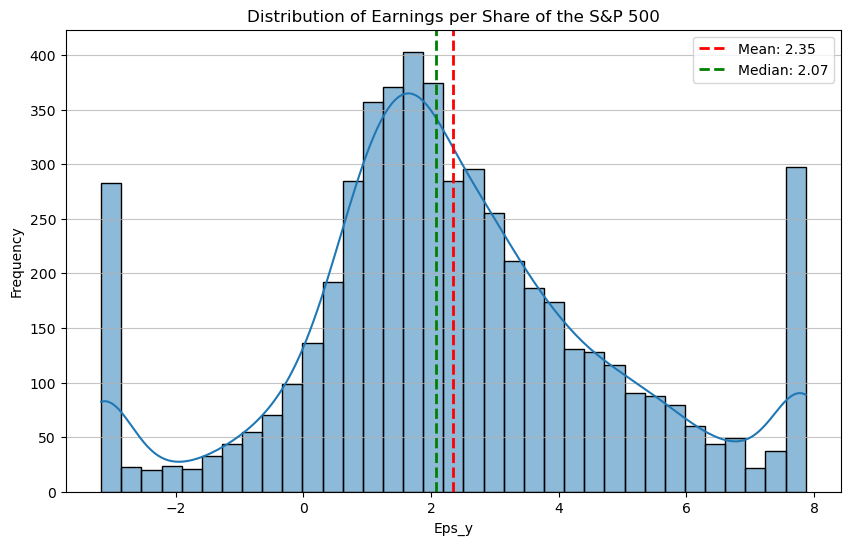

In [18]:
mean_eps_y = sp500_winsorized['eps_y'].mean()
median_eps_y = sp500_winsorized['eps_y'].median()

plt.figure(figsize=(10, 6))
sns.histplot(sp500_winsorized['eps_y'], bins='auto', kde=True)
plt.axvline(mean_eps_y, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_eps_y:.2f}')
plt.axvline(median_eps_y, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_eps_y:.2f}')
plt.title('Distribution of Earnings per Share of the S&P 500')
plt.xlabel('Eps_y')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()


Representative for the overall dataset after windsorizing, one can see the 'inflated' tails on the very far sides of the histogram.
This is due to the fact that the windsorizing process has cut the distrubution of the data on the left and right side respectively and put it into the most outside bucket that was mainted without alteration.

One can see that most companies are profitable with the mean laying at 2.39.

#### Correlation Heatmap - Top 10 Correlated Predictors (to Target Variable)

Top 10 features correlated with eps_y_forward:
  1. eps_y (r = 0.684)
  2. inc_rea_ps_y (r = 0.442)
  3. fcf_ps_y (r = 0.414)
  4. marg_profit_y (r = 0.298)
  5. be_ps_y (r = 0.284)
  6. dps_y (r = 0.276)
  7. goodwill_ps_y (r = 0.204)
  8. ass_ps_y (r = 0.195)
  9. cf_inv_ps_y (r = 0.168)
  10. g_dps_y (r = 0.165)


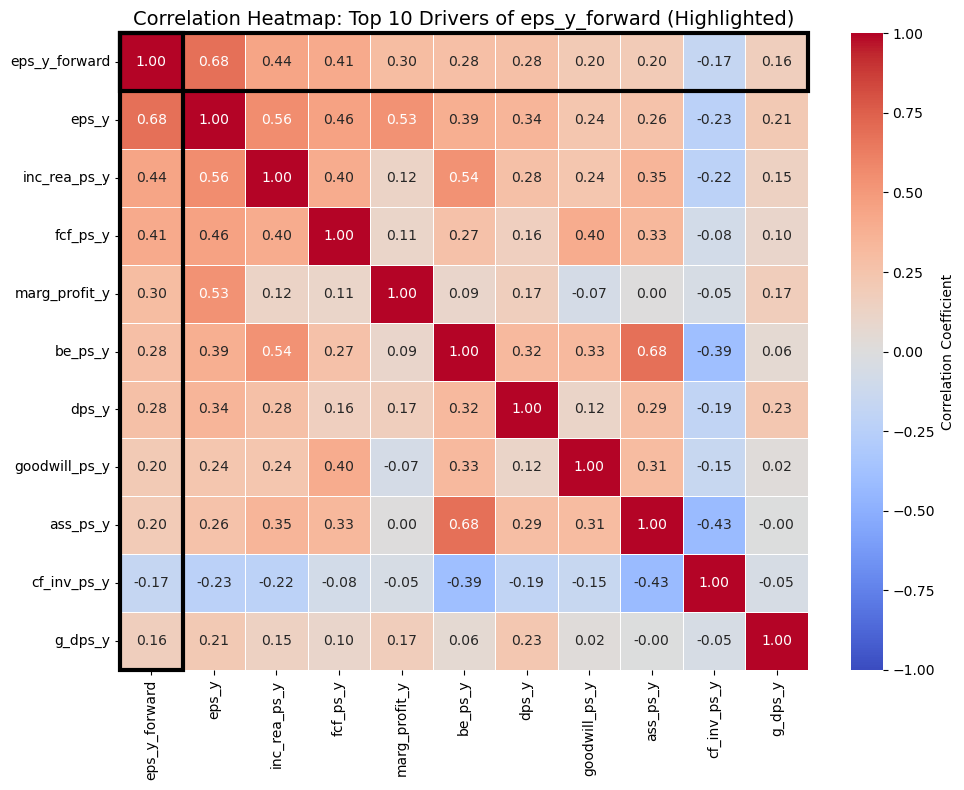

In [19]:
# select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])
target = 'eps_y_forward'  # UPDATED TARGET

# define columns to exclude from feature selection
exclude_y_features = ['neg_eps_forward', 'neg_eps', 'eps_y_forward']  # Exclude target and related variables

# select Top 10 features + target
if target in numeric_df.columns:
    # Filter out excluded columns before calculating correlations
    feature_candidates = numeric_df.drop(columns=exclude_y_features, errors='ignore')
    
    # get correlations of remaining features against 'eps_y_forward'
    correlations = feature_candidates.corrwith(numeric_df[target]).abs()
    
    # sort and take top 10 (best predictors only, excluding target)
    top_10_features = correlations.sort_values(ascending=False).head(10).index.tolist()
    
    # add target back to create final feature list
    top_features = [target] + top_10_features
    
    print(f"Top 10 features correlated with {target}:")
    for i, feat in enumerate(top_10_features, 1):
        print(f"  {i}. {feat} (r = {correlations[feat]:.3f})")
    
    # create heatmap
    plt.figure(figsize=(10, 8))
    corr_matrix = numeric_df[top_features].corr()
    
    # plot heatmap
    ax = sns.heatmap(
        corr_matrix, 
        annot=True, 
        fmt=".2f", 
        cmap='coolwarm', 
        vmin=-1, vmax=1,
        linewidths=0.5,
        cbar_kws={'label': 'Correlation Coefficient'}
    )
        
    # highlight the target row and column
    # find where 'eps_y_forward' is in the list (should be index 0)
    target_idx = top_features.index(target)
    n_vars = len(top_features)
    
    # draw rectangle around the target Column
    ax.add_patch(Rectangle((target_idx, 0), 1, n_vars, fill=False, edgecolor='black', lw=3, clip_on=False))
    
    # draw rectangle around the target row
    ax.add_patch(Rectangle((0, target_idx), n_vars, 1, fill=False, edgecolor='black', lw=3, clip_on=False))
    
    plt.title(f"Correlation Heatmap: Top 10 Drivers of {target} (Highlighted)", fontsize=14)
    plt.tight_layout()
    plt.show()

else:
    print(f"Target '{target}' not found in DataFrame. Did you run the shift code?")

From this visualization, we can see that profit margin, free cash flow per share, and book value per share are most highly correlated to the target variable (earning per share).

## 2. Modelling

### 2.1. Traditional Econometrics Approach

### 2.1.1 Entire Time Span

#### Regression

As we move up in complexity and this is supposed to create a baseline, we use the simple approach of choosing the top 4 features with highest correlation to the target variable. Having in mind that this is likely to not yield the best results possible, it still gives us a first baseline to compare against, given the time constraints.
Also we will not scale the features, as it is not necessary for these simple models and helps interpretation.

In [20]:
features_reg_all = [
    'eps_y',           # Earnings per share in previous year
    'inc_rea_ps_y',    # Realized Income per share
    'fcf_ps_y',        # Free Cash Flow per share
    'marg_profit_y',   # Profit Margin
]

In [21]:
#create X_train set
X_train_reg_all = X_full[features_reg_all]


# fit the linear regression model
lin_reg = LinearRegression()


lin_reg.fit(X_train_reg_all, y_full_reg)

# create a table of factors (coefficients)
factors_df = pd.DataFrame({
    'Feature': features_reg_all,
    'Factor (Coefficient)': lin_reg.coef_
})

# add the intercept as the first row
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Factor (Coefficient)': [lin_reg.intercept_]})
factors_df = pd.concat([intercept_row, factors_df], ignore_index=True)

# print results
print("\n--- Regression Coefficients ---")
print(factors_df)


--- Regression Coefficients ---
         Feature  Factor (Coefficient)
0      Intercept              0.645633
1          eps_y              0.650706
2   inc_rea_ps_y              0.006873
3       fcf_ps_y              0.102087
4  marg_profit_y             -1.307320


#### Interpretation of results
- Most of the coefficients are small - indicating either the scaling paradox or being a rather weak predictor
- Baseline Expectation: The Intercept (0.65) sets a positive baseline for future earnings, reflecting the inherent long-term upward trend in earnings of S&P 500 companies
- Primary Driver (Persistence): Current earnings per share (eps_y) is the strongest predictor (0.65), implying that $0.65 of every dollar earned today persists into next year regardless of other factors
- The Scaling Paradox: Features with large numerical values (e.g., inc_rea_ps_y) naturally display tiny coefficients (0.007) to offset their magnitude. This is a mathematical adjustment, not necessarily a sign of insignificance
- Margin: Profit Margin (marg_profit_y) has a large negative coefficient (-1.31) - this could be due to collinearity with e.g. eps_y weakening the strong effect on the dependent variable
- Other potential margin interpretation (Competition): Extremely high profit margins attract competition, leading to price erosion and margin contraction in subsequent years.


#### Classification

In [22]:



# max_iter=1000 ensures it converges even with unscaled data
log_reg = LogisticRegression(fit_intercept=True, max_iter=1000) 
log_reg.fit(X_train_reg_all, y_full_class)

# 4. Create Table of Factors (Coefficients)
log_factors_df = pd.DataFrame({
    'Feature': features_reg_all,
    'Factor (Coefficient)': log_reg.coef_[0] # Note the [0] index for binary classification
})

# Add Intercept
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Factor (Coefficient)': [log_reg.intercept_[0]]})
log_factors_df = pd.concat([intercept_row, log_factors_df], ignore_index=True)

# 5. Print Results
print("\n--- Logistic Regression Coefficients (Log-Odds) ---")
print(log_factors_df)


--- Logistic Regression Coefficients (Log-Odds) ---
         Feature  Factor (Coefficient)
0      Intercept             -1.159384
1          eps_y             -0.422185
2   inc_rea_ps_y              0.005779
3       fcf_ps_y             -0.012307
4  marg_profit_y             -3.316840


#### Interpretation of results
- Baseline Probability (Safety): The Intercept is strongly negative (-1.15) confirming that the "default state" of an S&P 500 company is profitable - the probability of a company posting a loss (without knowing any other data) is statistically low
- The "Buffer" Effect (Profit Margin): Unlike the linear regression where margins were penalized, marg_profit_y has a massive negative coefficient (-3.31) Even if a company with very high margins suffers a setback, their profit margin might decrease, but they are unlikely to drop below zero into a loss
- Primary Defense (Persistence): Current EPS (eps_y) is negative (-0.42) but significantly lower than the other two coefficients, confirming, however, that current profitability is a good insurance against future loss

- Model Contrast (Key Insight): The most important finding is the behavior of Profit Margin.
    - In Linear Model: It was negative (Margins revert to mean, dragging down growth).
    - In Logistic Model: It is negative (Margins prevent losses).
    - Conclusion could be: High margins limit your upside growth (due to competition) but protect your downside survival.

### 2.1.2 Model Evaluation on 2016 data

#### Regression

In [23]:
X_train_reg = X_train.copy()[features_reg_all]
X_test_reg = X_test.copy()[features_reg_all]


# fit the model
lin_reg_triv = LinearRegression()
lin_reg_triv.fit(X_train_reg, y_train_reg)

# predict
Y_pred_reg = lin_reg_triv.predict(X_test_reg)

# evaluate
mse_test = mean_squared_error(y_test_reg, Y_pred_reg)
r2_test = r2_score(y_test_reg, Y_pred_reg)
rmse_test = np.sqrt(mse_test) # Root MSE is easier to interpret ($)

# print results
print("\n--- Model Evaluation (Out-of-Sample) ---")
print(f"Test R²:  {r2_test:.4f}")
print("-" * 30)
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: ${rmse_test:.2f} per share")


--- Model Evaluation (Out-of-Sample) ---
Test R²:  0.6000
------------------------------
Test MSE: 3.4746
Test RMSE: $1.86 per share


#### Interpretation

- R^2: The model captures 60% of the variance in next year’s earnings is a reasonable fit - however, R^2 also increases with the number of features included in the model (that do not necessarily add value), so this is to be seen with a grain of salt
- Poor Performance: The Root Mean Squared Error ($1.86) is close to the average EPS ($2.3335) - indicating high relative error
- Baseline Performance: Not performing very well, but a good baseline to compared to more sophisticated models


#### Classification

In [24]:
X_train_class = X_train.copy()[features_reg_all]
X_test_class = X_test.copy()[features_reg_all]

# fit the logistic regression model
# We use the new Class targets (Y_train_class, Y_test_class)
log_reg_split = LogisticRegression(fit_intercept=True, max_iter=1000) 
log_reg_split.fit(X_train_class, y_train_class)

# predict
y_pred_train_class = log_reg_split.predict(X_train_class)
y_pred_test_class = log_reg_split.predict(X_test_class)

# evaluate (accuracy)
acc_train = accuracy_score(y_train_class, y_pred_train_class)
acc_test = accuracy_score(y_test_class, y_pred_test_class)

# create table of coefficients
log_factors_split_df = pd.DataFrame({
    'Feature': features_reg_all,
    'Factor (Coefficient)': log_reg_split.coef_[0]
})

# add intercept
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Factor (Coefficient)': [log_reg_split.intercept_[0]]})
log_factors_split_df = pd.concat([intercept_row, log_factors_split_df], ignore_index=True)

# print results
print("\n--- Classification Model Evaluation (Out-of-Sample) ---")

print(f"Train Accuracy: {acc_train:.4f} ({(acc_train*100):.2f}%)")
print(f"Test Accuracy:  {acc_test:.4f}  ({(acc_test*100):.2f}%)")

print("\n--- Logistic Regression Coefficients (Log-Odds) ---")
print(log_factors_split_df)



--- Classification Model Evaluation (Out-of-Sample) ---
Train Accuracy: 0.8857 (88.57%)
Test Accuracy:  0.8964  (89.64%)

--- Logistic Regression Coefficients (Log-Odds) ---
         Feature  Factor (Coefficient)
0      Intercept             -1.238728
1          eps_y             -0.391935
2   inc_rea_ps_y              0.001116
3       fcf_ps_y              0.009985
4  marg_profit_y             -3.018546


At first sight, 88.61% accuracy seems to be a good result. However, when comparing the data to the distribution in the dataset, we can see that the majority of the data is 0 (no negative earnings).

In [25]:
neg_ratio = y_full_class.mean()
neg_ratio

0.12773109243697478

The model performs just a bit better thana random guess. This could show that the model just predicts the majority class (0) all the time - lets assess this.

In [26]:
print(pd.Series(y_pred_test_class).value_counts(normalize=True))

0.0    0.929091
1.0    0.070909
Name: proportion, dtype: float64


- Even though the model predicts non-negative earnings more often, it does not 'just' always predict 0, which is a good indicator
- As train & test accuracy are similar, there is no indication of extreme overfitting
- Overall the model works as a solid baseline - we could show that there are no major issues that would make the model questionable
- Again the profit margin is the largest indicator for a positive earnings in the future
- The intercept is very large again, indicating a general tendency for positive earnings

### Additional Model - Elastic Net
Since the Regression model did not perform well, we will use an elastic net  model to counter the weaknesses of the 'standard' linear model:
1. Automatic Feature Selection
- L1 penalty drives irrelevant coefficients to exactly zero
- Reduces predictors space to a sparse, interpretable model
- Eliminates noise variables automatically

2. Handles Multicollinearity
- L2 penalty stabilizes estimates when predictors are correlated
- Financial ratios often correlate (e.g., eps_y and dps_y, ass_tot_ps_y and be_ps_y)

3. Best of Both Worlds
- Lasso alone: Good for selection, still weakness with collinearity
- Ridge alone: Stable but keeps all features slightly >0
- Elastic Net: Achieves both in one model

In [27]:


# build pipeline (scaler + model)
# this ensures we fit the scaler ONLY on X_train, then transform X_test
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('enet', ElasticNet(random_state=42))
])

# define hp to tune
param_grid = {
    'enet__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'enet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]
}

# run gs - cv
print("--- Tuning Elastic Net (This may take a moment) ---")
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train_reg)

# get best model & predict
best_model = grid_search.best_estimator_
y_pred_enet = best_model.predict(X_test)

# evaluate
mse_enet = mean_squared_error(y_test_reg, y_pred_enet)
rmse_enet = np.sqrt(mse_enet)
r2_enet = r2_score(y_test_reg, y_pred_enet)

# extract coefficients (handling the pipeline structure)
# Access the 'enet' step inside the pipeline
best_coefs = best_model.named_steps['enet'].coef_

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'ENet Coefficient': best_coefs
}).sort_values(by='ENet Coefficient', ascending=False)

# print results
print(f"\nBest Parameters: {grid_search.best_params_}")
print("-" * 40)
print(f"Test R²:  {r2_enet:.4f}")
print(f"Test RMSE: ${rmse_enet:.2f}")
print("-" * 40)
print("\n--- Standardized Coefficients (Impact Strength) ---")
print(coef_df)


--- Tuning Elastic Net (This may take a moment) ---

Best Parameters: {'enet__alpha': 0.01, 'enet__l1_ratio': 1.0}
----------------------------------------
Test R²:  0.6065
Test RMSE: $1.85
----------------------------------------

--- Standardized Coefficients (Impact Strength) ---
          Feature  ENet Coefficient
23          eps_y          1.559843
19       fcf_ps_y          0.302402
3    inc_rea_ps_y          0.122240
4     invest_ps_y          0.104019
6           dps_y          0.083146
14      g_cf_op_y          0.040618
17        g_inv_y          0.021607
13   ncf_iad_ps_y          0.017013
9       rev_grw_y          0.013664
5    rev_def_ps_y          0.011514
15        g_dps_y          0.011200
21       payout_y          0.009526
22     turn_inv_y          0.000978
0           shr_y         -0.000000
10    cf_inv_ps_y         -0.000000
7    exp_r_d_ps_y          0.000000
2   goodwill_ps_y          0.000000
18        be_ps_y         -0.037358
20      inc_qua_y         -0.040

The model performs very similar to the 'standard' Linear Regression model. Therefore, we will move on to more sophisticated models and check if a more advanced architecture can yield better results.

## 2.2 Machine Learning Approach

### 2.2.1 Regression

In [28]:
xgb_reg = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1
)

# parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5]
}

#grid search with cross validation
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    n_jobs=-1,
    verbose=0
)

# fit grid search
grid_search.fit(X_train, y_train_reg)

# use the best model found by gs
xgb_reg = grid_search.best_estimator_

# predict on test and train
y_pred_test = xgb_reg.predict(X_test)
y_pred_train = xgb_reg.predict(X_train)

# evaluate

# test set
mse_test = mean_squared_error(y_test_reg, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test_reg, y_pred_test)

# train set
mse_train = mean_squared_error(y_train_reg, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train_reg, y_pred_train)

# feature importance
feat_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_reg.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

# print results
print("\n--- XGBoost Model Evaluation ---")
print(f"Best Params: {grid_search.best_params_}")

print("\nTRAIN performance:")
print(f"Train R²:   {r2_train:.4f}")
print(f"Train RMSE: ${rmse_train:.2f}")

print("\nTEST performance:")
print(f"Test R²:    {r2_test:.4f}")
print(f"Test RMSE:  ${rmse_test:.2f}")

print("-" * 30)
print("\n--- Top 10 Feature Importances ---")
print(feat_importances)


--- XGBoost Model Evaluation ---
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

TRAIN performance:
Train R²:   0.5696
Train RMSE: $1.65

TEST performance:
Test R²:    0.6070
Test RMSE:  $1.85
------------------------------

--- Top 10 Feature Importances ---
          Feature  Importance
23          eps_y    0.357621
19       fcf_ps_y    0.078000
3    inc_rea_ps_y    0.054860
20      inc_qua_y    0.052516
5    rev_def_ps_y    0.040561
16        g_eps_y    0.034903
8   marg_profit_y    0.034087
2   goodwill_ps_y    0.028884
4     invest_ps_y    0.027327
14      g_cf_op_y    0.026873


#### Interpretation
- As xgb does not clearly outperform e.g. linear regression models, there might be a close-to-linear relationship that a lin. regression model is able to capture as well
- This might also be related to the Winsorizing done earlier
    - This might have significantly reduced the non-linear characteristics of the data resulting in a performance close to the linear models
- Accordingly, in a more extensive project, one could leave the barrier wider undtil outliers are treated and use an alternative method for it

#### Evaluation metrics
- Test R^2: 0.60 - Model explains 60% of EPS variance which is a moderate performance
- Test RMSE: $1.86 → Average prediction error of ~$1.86 per share (errors are squqred before being averaged)
- Train vs Test gap small (R^2: 0.57 -> 0.60) → Good generalization, no overfitting

#### Main coefficients

- eps_y (35.8%) - Current EPS is by far the strongest predictor (autoregressive)
- fcf_ps_y (8.2%) - Free cash flow per share (profitability indicator)


### 2.2.2 Classification

In [29]:
# define model ----
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

# parameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5]
}

# grid search with cv
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1',     # or accuracy / roc_auc depending on your task
    cv=3,
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train, y_train_class)

# best model
xgb_clf = grid_search.best_estimator_

# predict
y_pred_train = xgb_clf.predict(X_train)
y_pred_test  = xgb_clf.predict(X_test)

# evaluate
train_acc = accuracy_score(y_train_class, y_pred_train)
train_f1  = f1_score(y_train_class, y_pred_train)

test_acc  = accuracy_score(y_test_class, y_pred_test)
test_f1   = f1_score(y_test_class, y_pred_test)

# feature importance
feat_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_clf.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

# print results
print("\n--- XGBoost CLASSIFIER Model Evaluation ---")
print(f"Best Params: {grid_search.best_params_}")
print("-" * 60)

print("TRAIN performance:")
print(f"Accuracy: {train_acc:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("-" * 60)

print("TEST performance:")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print("-" * 60)

print("\nClassification Report (TEST):")
print(classification_report(y_test_class, y_pred_test))


--- XGBoost CLASSIFIER Model Evaluation ---
Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
------------------------------------------------------------
TRAIN performance:
Accuracy: 0.9164
F1 Score: 0.5686
------------------------------------------------------------
TEST performance:
Accuracy: 0.8818
F1 Score: 0.4628
------------------------------------------------------------

Classification Report (TEST):
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93       464
         1.0       0.80      0.33      0.46        86

    accuracy                           0.88       550
   macro avg       0.84      0.66      0.70       550
weighted avg       0.87      0.88      0.86       550



In [30]:
print("\n--- Top 10 Feature Importances ---")
print(feat_importances)


--- Top 10 Feature Importances ---
          Feature  Importance
23          eps_y    0.338481
20      inc_qua_y    0.065177
16        g_eps_y    0.044638
21       payout_y    0.039463
19       fcf_ps_y    0.038223
8   marg_profit_y    0.037360
18        be_ps_y    0.034598
1        ass_ps_y    0.032661
7    exp_r_d_ps_y    0.030495
3    inc_rea_ps_y    0.027818


#### Interpretation
- Model again, performs close to data distribution showing moderate performance
- Train accuracy > Test accuracy - shows small indication of overfitting
- Data balancing (e.g. SMOTE) helpful in more extensive project


#### Evaluation metrics
- Model achieves higher f1 score on non-negative earnings predictions showing weakness on less occurring data samples
- Class imbalance: 464 positive vs 86 negative (84% vs 16%)
- as the threshold for switching to prediction of negative earnings seems to be very high, model shows quite high precision, once it predicts a negative earnings

#### Main coefficients
- again strongest coefficients (as already touched upon before):
    - earning of current (previous year) - eps_y
    - free cash flow - fcf_ps_y